# Project Kindle 
This project does sentiment analysis of amazon reviews on Kindle e-books using scikit-learn machine learning tools. 

The data is taken from Julian McAuley's website:
http://jmcauley.ucsd.edu/data/amazon/index.html 

To run the code, one also needs to download Google's trained Word2Vec model: http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

In [1]:
# this cell imports all the necessary packages/libraries related to the project
import numpy as np
import scipy 
import json
import pandas as pd
import gzip
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import model_selection  
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster
from sklearn.preprocessing import normalize
from sklearn.externals import joblib

import string


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec

IMPORTING THE PRE-TRAINED WORD2VEC 

In [2]:
# model is a pretrained text file that is available for use in the Word2Vec library.
model =  word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

READING THE FILE

In [3]:
# Code taken from: http://jmcauley.ucsd.edu/data/amazon/index.html
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
# Code taken from: http://jmcauley.ucsd.edu/data/amazon/index.html
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.dumps(eval(l))

f = open("output.strict", 'w')
for l in parse("reviews_Kindle_Store_5.json.gz"):
    f.write(l + '\n')

In [5]:
# Code taken from: http://jmcauley.ucsd.edu/data/amazon/index.html
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Kindle_Store_5.json.gz')

CLEANING THE DATA

In [6]:
df2=df[:2000]

In [7]:
del df2['reviewerID']
del df2['reviewerName']
del df2['summary']
del df2['helpful']
del df2['unixReviewTime']
del df2['reviewTime']

In [8]:
df2.head()

,asin,reviewText,overall
0,B000F83SZQ,I enjoy vintage books and movies so I enjoyed ...,5.0
1,B000F83SZQ,This book is a reissue of an old one; the auth...,4.0
2,B000F83SZQ,This was a fairly interesting read. It had ol...,4.0
3,B000F83SZQ,I'd never read any of the Amy Brewster mysteri...,5.0
4,B000F83SZQ,"If you like period pieces - clothing, lingo, y...",4.0


In [9]:
df2.shape

(2000, 3)

In [10]:
df2= df2.set_index("asin")

In [11]:
df2_overall= pd.get_dummies(df2["overall"])

In [12]:
df2.head()

,reviewText,overall
asin,,
B000F83SZQ,I enjoy vintage books and movies so I enjoyed ...,5.0
B000F83SZQ,This book is a reissue of an old one; the auth...,4.0
B000F83SZQ,This was a fairly interesting read. It had ol...,4.0
B000F83SZQ,I'd never read any of the Amy Brewster mysteri...,5.0
B000F83SZQ,"If you like period pieces - clothing, lingo, y...",4.0


FEATURE SCALING

In [13]:
#Creating dummies for the column: overall
df3= pd.concat([df2,df2_overall], axis=1)
df3.head()

,reviewText,overall,1.0,2.0,3.0,4.0,5.0
asin,,,,,,,
B000F83SZQ,I enjoy vintage books and movies so I enjoyed ...,5.0,0,0,0,0,1
B000F83SZQ,This book is a reissue of an old one; the auth...,4.0,0,0,0,1,0
B000F83SZQ,This was a fairly interesting read. It had ol...,4.0,0,0,0,1,0
B000F83SZQ,I'd never read any of the Amy Brewster mysteri...,5.0,0,0,0,0,1
B000F83SZQ,"If you like period pieces - clothing, lingo, y...",4.0,0,0,0,1,0


In [14]:
#creating a new column: score with values pre-set as 0
df3["score"]= [0]*len(df3)
df3.head()

,reviewText,overall,1.0,2.0,3.0,4.0,5.0,score
asin,,,,,,,,
B000F83SZQ,I enjoy vintage books and movies so I enjoyed ...,5.0,0,0,0,0,1,0
B000F83SZQ,This book is a reissue of an old one; the auth...,4.0,0,0,0,1,0,0
B000F83SZQ,This was a fairly interesting read. It had ol...,4.0,0,0,0,1,0,0
B000F83SZQ,I'd never read any of the Amy Brewster mysteri...,5.0,0,0,0,0,1,0
B000F83SZQ,"If you like period pieces - clothing, lingo, y...",4.0,0,0,0,1,0,0


In [15]:
#adding columns: 4.0 & 5.0. What we get is a column score that has value 1 
#when the overall (rating) is 4 or 5 and 0 otherwise

df3["score"]=df3[4.0]+df3[5.0]

In [16]:
df3.head()

,reviewText,overall,1.0,2.0,3.0,4.0,5.0,score
asin,,,,,,,,
B000F83SZQ,I enjoy vintage books and movies so I enjoyed ...,5.0,0,0,0,0,1,1
B000F83SZQ,This book is a reissue of an old one; the auth...,4.0,0,0,0,1,0,1
B000F83SZQ,This was a fairly interesting read. It had ol...,4.0,0,0,0,1,0,1
B000F83SZQ,I'd never read any of the Amy Brewster mysteri...,5.0,0,0,0,0,1,1
B000F83SZQ,"If you like period pieces - clothing, lingo, y...",4.0,0,0,0,1,0,1


In [17]:
#cleaning the dataset
del df3[1.0]
del df3[2.0]
del df3[3.0]
del df3[4.0]
del df3[5.0]


TOKENIZING AND SPLITTING

In [18]:
df3.reviewText = df3.reviewText.apply(lambda x: x.lower())

In [19]:
#Code taken from: https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [20]:
df3.reviewText = df3.reviewText.apply(remove_punctuations)

In [21]:
#converting reviews to lists (tokenizing and splitting)
tokenized = df3.reviewText.str.split().tolist()

In [24]:
stop_words = open('englishstopwords.txt','r+')

In [28]:
tokenized_n = []
for sublist in tokenized:
    for item in sublist:
        if item in stop_words:
            break
        tokenized_n.append(sublist)
        break

In [30]:
tokenized_n=tokenized

WORD EMBEDDING AND SENTENCE EMBEDDING -With Normalization

In [32]:
semd=[]
for item in tokenized:
    wemd=np.zeros(300)
    for w in item:
         if w in model:
                wemd = np.add(model[w],wemd)
                normed= wemd/np.linalg.norm(wemd)
    semd.append(normed)
print(semd)    
                    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
scorelist = df3["score"].tolist()
scorelist = np.asarray(scorelist)

MACHINE LEARNING PART:
Applying different classification algorithms to the data:
1. With Binary Classification
    1.1. Logistic Regression
    1.2. support-vector machine with linear kernel
    1.3. decision trees
    1.4. random forest method
2. With Multi-layer Classification
    2.1. Logistic Regression
    2.2. support-vector machine with linear kernel
    2.3. decision trees
    2.4. random forest method


1.  Binary Classification

1.1. Logistic Regression

In [34]:
X_train, X_test, y_train, y_test= model_selection.train_test_split(semd,scorelist, train_size=0.7)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [35]:
classifier_lr= linear_model.LogisticRegression()
classifier_lr.fit(X_train, y_train)
y_test_pred_lr= classifier_lr.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [36]:
print(metrics.classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.05      0.10       156
           1       0.75      1.00      0.86       444

   micro avg       0.75      0.75      0.75       600
   macro avg       0.82      0.52      0.48       600
weighted avg       0.79      0.75      0.66       600



In [37]:
metrics.confusion_matrix(y_test, y_test_pred_lr)


array([[  8, 148],
       [  1, 443]])

In [38]:
metrics.accuracy_score(y_test, y_test_pred_lr, normalize=True, sample_weight=None)

0.7516666666666667

1.2. SVM

In [39]:
classifier_svm= svm.SVC()
classifier_svm.fit(X_train, y_train)
y_test_pred_svm=classifier_svm.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [40]:
print(metrics.classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       156
           1       0.74      1.00      0.85       444

   micro avg       0.74      0.74      0.74       600
   macro avg       0.37      0.50      0.43       600
weighted avg       0.55      0.74      0.63       600



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
metrics.confusion_matrix(y_test, y_test_pred_svm)

array([[  0, 156],
       [  0, 444]])

In [42]:
metrics.accuracy_score(y_test, y_test_pred_svm, normalize=True, sample_weight=None)

0.74

1.3. Decision Trees

In [43]:
classifier_dt= tree.DecisionTreeClassifier()
classifier_dt.fit(X_train, y_train)
y_test_pred_dt= classifier_dt.predict(X_test)

In [44]:
print(metrics.classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.42      0.35      0.38       156
           1       0.79      0.83      0.81       444

   micro avg       0.71      0.71      0.71       600
   macro avg       0.60      0.59      0.60       600
weighted avg       0.69      0.71      0.70       600



In [45]:
metrics.confusion_matrix(y_test, y_test_pred_dt)

array([[ 55, 101],
       [ 75, 369]])

In [46]:
metrics.accuracy_score(y_test, y_test_pred_dt, normalize=True, sample_weight=None)

0.7066666666666667

1.4. Random Forest

In [47]:
classifier_rf= ensemble.RandomForestClassifier()
classifier_rf.fit(X_train, y_train)
y_test_pred_rf= classifier_rf.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [48]:
print(metrics.classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.67      0.27      0.38       156
           1       0.79      0.95      0.86       444

   micro avg       0.78      0.78      0.78       600
   macro avg       0.73      0.61      0.62       600
weighted avg       0.76      0.78      0.74       600



In [49]:
metrics.confusion_matrix(y_test, y_test_pred_rf)

array([[ 42, 114],
       [ 21, 423]])

In [50]:
metrics.accuracy_score(y_test, y_test_pred_rf, normalize=True, sample_weight=None)

0.775

Saving our Logistic Regression model to use later for predicting the rating of a new review.

In [52]:
# Output a pickle file for the Logistic Regression model
joblib.dump(classifier_lr, 'saved_model.pkl')

['saved_model.pkl']

In [53]:
classifier_lr_load = joblib.load('saved_model.pkl') 

In [54]:
assert classifier_lr.score(semd, scorelist) == classifier_lr_load.score(semd, scorelist)

In [55]:
result =classifier_lr_load.score(X_test, y_test)
print(result)

0.7516666666666667


In [56]:
#the function gets a new review, tokenizes it, 
#and gives back a vector of size 300 for the review
def test_new_data(x):
    remove_punctuations(x)
    tokenize_x = x.split()
    semd_x=[]
    for item in tokenize_x:
        wemd=np.zeros(300)
        for w in item:
             if w in model:
                wemd = np.add(model[w],wemd)
                normed= wemd/np.linalg.norm(wemd)
        semd_x.append(normed)
        return semd_x
    
    

In [57]:
# Using our model to classify a new text

Xnew=test_new_data("I love this book. It is so inspiring! \
I would definately recommend buying it")

In [58]:
ynew = classifier_lr_load.predict(Xnew)
print(ynew)

[1]


2. With Multi-label Classification

In [59]:
overall = df3["overall"].tolist()

2.1. Logistic Regression

In [60]:
X_train, X_test, y_train, y_test= model_selection.train_test_split(semd,overall, train_size=0.7)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [61]:
classifier_lr= linear_model.LogisticRegression()
classifier_lr.fit(X_train, y_train)
y_test_pred_lr= classifier_lr.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [62]:
print(metrics.classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        22
         2.0       0.00      0.00      0.00        26
         3.0       0.62      0.06      0.10        89
         4.0       0.30      0.17      0.22       163
         5.0       0.58      0.97      0.73       300

   micro avg       0.54      0.54      0.54       600
   macro avg       0.30      0.24      0.21       600
weighted avg       0.47      0.54      0.44       600



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
metrics.confusion_matrix(y_test, y_test_pred_lr)


array([[  0,   0,   0,   7,  15],
       [  0,   0,   0,  12,  14],
       [  0,   0,   5,  37,  47],
       [  0,   0,   3,  28, 132],
       [  0,   0,   0,   8, 292]])

In [64]:
metrics.accuracy_score(y_test, y_test_pred_lr, normalize=True, sample_weight=None)

0.5416666666666666

2.2. SVM

In [65]:
classifier_svm= svm.SVC()
classifier_svm.fit(X_train, y_train)
y_test_pred_svm=classifier_svm.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [66]:
print(metrics.classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        22
         2.0       0.00      0.00      0.00        26
         3.0       0.00      0.00      0.00        89
         4.0       0.00      0.00      0.00       163
         5.0       0.50      1.00      0.67       300

   micro avg       0.50      0.50      0.50       600
   macro avg       0.10      0.20      0.13       600
weighted avg       0.25      0.50      0.33       600



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
metrics.confusion_matrix(y_test, y_test_pred_svm)

array([[  0,   0,   0,   0,  22],
       [  0,   0,   0,   0,  26],
       [  0,   0,   0,   0,  89],
       [  0,   0,   0,   0, 163],
       [  0,   0,   0,   0, 300]])

In [68]:
metrics.accuracy_score(y_test, y_test_pred_svm, normalize=True, sample_weight=None)

0.5

2.3. Decision Trees

In [69]:
classifier_dt= tree.DecisionTreeClassifier()
classifier_dt.fit(X_train, y_train)
y_test_pred_dt= classifier_dt.predict(X_test)

In [70]:
print(metrics.classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

         1.0       0.03      0.05      0.04        22
         2.0       0.10      0.15      0.12        26
         3.0       0.21      0.17      0.19        89
         4.0       0.27      0.26      0.26       163
         5.0       0.56      0.57      0.57       300

   micro avg       0.39      0.39      0.39       600
   macro avg       0.24      0.24      0.23       600
weighted avg       0.39      0.39      0.39       600



In [71]:
metrics.confusion_matrix(y_test, y_test_pred_dt)

array([[  1,   3,   3,   7,   8],
       [  3,   4,   5,   4,  10],
       [  6,   7,  15,  29,  32],
       [  9,  10,  21,  42,  81],
       [ 14,  16,  28,  72, 170]])

In [72]:
metrics.accuracy_score(y_test, y_test_pred_dt, normalize=True, sample_weight=None)

0.38666666666666666

4.4. Random Forest

In [73]:
classifier_rf= ensemble.RandomForestClassifier()
classifier_rf.fit(X_train, y_train)
y_test_pred_rf= classifier_rf.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [74]:
print(metrics.classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        22
         2.0       0.10      0.08      0.09        26
         3.0       0.28      0.19      0.23        89
         4.0       0.35      0.29      0.32       163
         5.0       0.59      0.75      0.66       300

   micro avg       0.48      0.48      0.48       600
   macro avg       0.26      0.26      0.26       600
weighted avg       0.44      0.48      0.45       600



In [75]:
metrics.confusion_matrix(y_test, y_test_pred_rf)

array([[  0,   2,   2,   8,  10],
       [  0,   2,   8,   1,  15],
       [  1,   5,  17,  29,  37],
       [  0,   5,  15,  48,  95],
       [  1,   6,  18,  51, 224]])

In [76]:
metrics.accuracy_score(y_test, y_test_pred_rf, normalize=True, sample_weight=None)

0.485

Interim Conclusion: 
1. There is not much difference between various classifiers! 
2. Multi-label classifiers act poorly compared to binary classifiers. Maybe it is because of the fact that more dimensions confuse the model. 

Plotting different training and testing sample sizes to compare four classifiers for binary classification. 

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_spl

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:2

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:2

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:2

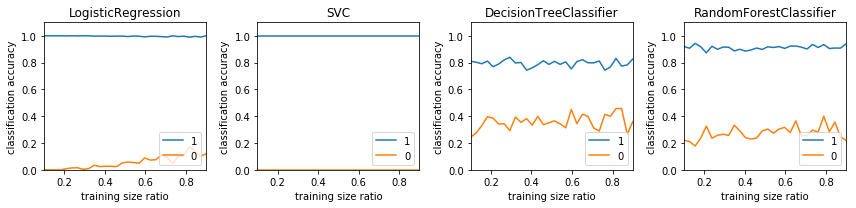

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
# create a numpy array with training size ratios, ranging from 10% to 90%
train_size_vec = np.linspace(0.1, 0.9, 30)

# create a list of classifiers
classifiers = [linear_model.LogisticRegression,
               svm.SVC,
                tree.DecisionTreeClassifier,
               ensemble.RandomForestClassifier
              ]

# create an array that stores the diagonals of the confusion matrix as a function of training size ratio
# and classifier
cm_diags = np.zeros((2, len(train_size_vec), len(classifiers)), dtype=float)
#print(cm_diags)
# loop over each training size ratio and classifier
for n, train_size in enumerate(train_size_vec):
    X_train, X_test, y_train, y_test = \
        model_selection.train_test_split(semd, scorelist, train_size=train_size)

    for m, Classifier in enumerate(classifiers): 
        classifier = Classifier()
        classifier.fit(X_train, y_train)
        y_test_pred = classifier.predict(X_test)
        cm_diags[:, n, m] = metrics.confusion_matrix(y_test, y_test_pred).diagonal()
        cm_diags[:, n, m] /= np.bincount(y_test)
        
# plot accuracy as a function of training size ratio
fig, axes = plt.subplots(1, len(classifiers), figsize=(12, 3))

for m, Classifier in enumerate(classifiers): 
    axes[m].plot(train_size_vec, cm_diags[1, :, m], label=1)
    axes[m].plot(train_size_vec, cm_diags[0, :, m], label=0)
   # axes[m].plot(train_size_vec, label=scorelist[1])
    #axes[m].plot(train_size_vec, label=scorelist[0])
    axes[m].set_title(type(Classifier()).__name__)
    axes[m].set_ylim(0, 1.1)
    axes[m].set_xlim(0.1, 0.9)
    axes[m].set_ylabel("classification accuracy")
    axes[m].set_xlabel("training size ratio")
    axes[m].legend(loc=4)

fig.tight_layout()